In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.special as ssp
import sys
import scipy.io as sio
sys.path.append("../code/")
from pi_vae import *
from util import *
from keras.callbacks import ModelCheckpoint

## import plot packages
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker
import seaborn

%load_ext autoreload
%autoreload 2
%matplotlib inline

## load rat data

In [2]:
## load data
rat_data = sio.loadmat("../data/achilles_data/Achilles_data.mat")

In [3]:
## load trial information
idx_split = rat_data['trial'][0]
## load spike data
spike_by_neuron_use = rat_data['spikes']
## load locations
locations_vec = rat_data['loc'][0]
## load lfp
tlfp_vec = rat_data['lfp'][0]

In [4]:
u_all = np.array(np.array_split(np.hstack((locations_vec.reshape(-1,1),np.zeros((locations_vec.shape[0],2)))), idx_split[1:-1], axis=0))
x_all = np.array(np.array_split(spike_by_neuron_use, idx_split[1:-1], axis=0))
for ii in range(len(u_all)):
    u_all[ii][:,int(ii%2)+1] = 1;
    
trial_ls = np.arange(len(u_all));
np.random.seed(666);
random_ls = np.random.permutation(trial_ls);

In [5]:
u_train = u_all[trial_ls[:68]];
x_train = x_all[trial_ls[:68]];

u_valid = u_all[trial_ls[68:76]];
x_valid = x_all[trial_ls[68:76]];

u_test = u_all[trial_ls[76:]];
x_test = x_all[trial_ls[76:]];

In [6]:
## fit pca
from sklearn.decomposition import PCA
pca_raw = PCA(n_components=2);
pca_raw_rlt = pca_raw.fit_transform(np.concatenate(x_all));

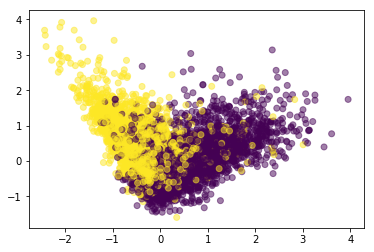

In [7]:
## plot pca results
plt.scatter(pca_raw_rlt[:,0], pca_raw_rlt[:,1], alpha=0.5, c=(np.concatenate(u_all)[:,-1]>0))

## fit pi-vae

In [8]:
np.random.seed(666);
vae = vae_mdl(dim_x=x_all[0].shape[-1], 
                   dim_z=2,
                   dim_u=u_all[0].shape[-1], 
                   gen_nodes=60, n_blk=2, mdl='poisson', disc=False, learning_rate=5e-4)

Instructions for updating:
Colocations handled automatically by placer.
Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 22668       input_1[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
decoder (Model)         

/home/dz2336/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output encoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to encoder.
  'be expecting any data to be passed to {0}.'.format(name))
/home/dz2336/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output encoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to encoder.
  'be expecting any data to be passed to {0}.'.format(name))
/home/dz2336/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output encoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to encoder.
  'be expecting any data to be passed to {0}.'.format(name))
/home/dz2336/anaconda3/lib/p

In [ ]:
model_chk_path = '../results/rat_2d_666_pivae.h5' ##999, 777
mcp = ModelCheckpoint(model_chk_path, monitor="val_loss", save_best_only=True, save_weights_only=True)
s_n = vae.fit_generator(custom_data_generator(x_train, u_train),
              steps_per_epoch=len(x_train), epochs=600, 
              verbose=1,
              validation_data = custom_data_generator(x_valid, u_valid),
              validation_steps = len(x_valid), callbacks=[mcp]);

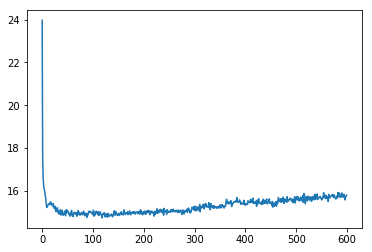

In [10]:
plt.plot(s_n.history['val_loss'][:])

In [11]:
vae.load_weights(model_chk_path);

In [12]:
outputs = vae.predict_generator(custom_data_generator(x_all, u_all),
                                                steps = len(x_all));
# post_mean, post_log_var, z_sample,fire_rate, lam_mean, lam_log_var, z_mean, z_log_var
print(outputs[0].var(axis=0))  ## variance of each latent dimension

[1.8860826 4.8043437]


In [13]:
z_pred_all = [];
for ii in range(len(x_all)):
    z_pred_all.append(vae.predict([x_all[ii], u_all[ii]])[0][:,:]);
z_pred_all = np.array(z_pred_all);

## make plots

In [14]:
def get_tc_rd(y, hd, hd_bins): # compute empirical tunning curve of data
    tuning_curve = np.zeros((len(hd_bins)-1, y.shape[1]));
    for ii in range(len(hd_bins)-1):
        data_pos = ((hd>=hd_bins[ii])*(hd<=hd_bins[ii+1]));
        tuning_curve[ii,:] = y[data_pos,:].mean(axis=0);
    return tuning_curve

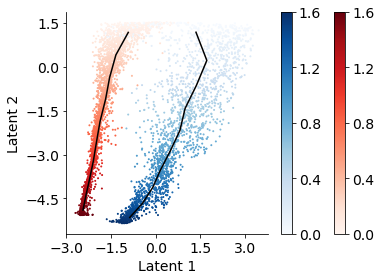

In [15]:
## posterior mean

ll = 11;
hd_bins = np.linspace(0,1.6,ll);
select = (np.concatenate(u_all)[:,1]==1);
tc1 = get_tc_rd(outputs[0][select], np.concatenate(u_all)[select,0], hd_bins);
select = (np.concatenate(u_all)[:,2]==1);
tc2 = get_tc_rd(outputs[0][select], np.concatenate(u_all)[select,0], hd_bins);

dis_mat = np.zeros((len(tc1), len(tc2)));
for jj in range(len(tc1)):
    dis_mat[jj] = np.sqrt(np.square(tc1[jj]-tc2).sum(axis=-1))

ll = 5000;
fig = plt.figure(figsize=(5.5,4))
ax = plt.subplot(111); #fig.add_subplot(111, projection='3d')
fsz = 14;
## learn locations
select = (np.concatenate(u_all)[:ll,1]==1);

im = ax.scatter(outputs[0][:ll][select][:,0], outputs[0][:ll][select][:,1],s=1,c=np.concatenate(u_all)[:ll][select,0],
           cmap='Reds',vmin=0,vmax=1.6);
ax.plot(tc1[:,0],tc1[:,1],c='black');
cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=14) 
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
## learn locations
select = (np.concatenate(u_all)[:ll][:,1]==0);

im = ax.scatter(outputs[0][:ll][select][:,0], outputs[0][:ll][select][:,1],s=1,c=np.concatenate(u_all)[:ll][select,0],
           cmap='Blues',vmin=0,vmax=1.6);
ax.plot(tc2[:,0],tc2[:,1],c='black');
cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=14) 
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
ax.set_xlabel('Latent 1', fontsize=fsz);
ax.set_ylabel('Latent 2', fontsize=fsz);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.setp(ax.get_xticklabels(), fontsize=fsz);
plt.setp(ax.get_yticklabels(), fontsize=fsz);

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=4,min_n_ticks=4,prune=None))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4,min_n_ticks=4,prune=None))

plt.tight_layout()

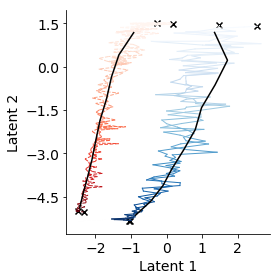

In [16]:
## posterior mean single trial trajectory

ndim = 0;
ll = 20;
fsz = 14;
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(111)
bins = np.linspace(np.concatenate(u_all)[:,ndim].min(),np.concatenate(u_all)[:,ndim].max(),ll);
centers = (bins[1:]+bins[:-1])/2;
lines = ['--', '-']
for ii in range(4):
    length = len(z_pred_all[ii]);
    disc_loc = np.digitize(u_all[ii][:,ndim],centers);
    if ii%2:
        c_vec = plt.cm.Blues(np.linspace(0,1,ll))#[::-1];
    else:
        c_vec = plt.cm.Reds(np.linspace(0,1,ll))#[::-1];
    
    c_all = c_vec[disc_loc];
    ax.scatter(z_pred_all[ii][0,0], z_pred_all[ii][0,1], marker='x',c='black')
    for jj in range(length-1):
        tmp = np.linspace(z_pred_all[ii][jj], z_pred_all[ii][jj+1], 10);
        ax.plot(tmp[:,0], tmp[:,1], lines[ii%2], c=c_all[jj], linewidth=1);
    ax.scatter(z_pred_all[ii][-1,0], z_pred_all[ii][-1,1],marker='x',c='black')
ax.plot(tc1[:,0],tc1[:,1],c='black');
ax.plot(tc2[:,0],tc2[:,1],c='black');
ax.set_xlabel('Latent 1', fontsize=fsz);
ax.set_ylabel('Latent 2', fontsize=fsz);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.setp(ax.get_xticklabels(), fontsize=fsz);
plt.setp(ax.get_yticklabels(), fontsize=fsz);

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=4,min_n_ticks=4,prune=None))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4,min_n_ticks=4,prune=None))
plt.tight_layout()

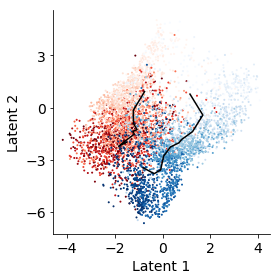

In [17]:
## posterior mean w/o prior

ll = 11;
hd_bins = np.linspace(0,1.6,ll);
select = (np.concatenate(u_all)[:,1]==1);
tc1 = get_tc_rd(outputs[6][select], np.concatenate(u_all)[select,0], hd_bins);
select = (np.concatenate(u_all)[:,2]==1);
tc2 = get_tc_rd(outputs[6][select], np.concatenate(u_all)[select,0], hd_bins);

dis_mat_no_pri = np.zeros((len(tc1), len(tc2)));
for jj in range(len(tc1)):
    dis_mat_no_pri[jj] = np.sqrt(np.square(tc1[jj]-tc2).sum(axis=-1))
    
ll = 5000;
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(111); #fig.add_subplot(111, projection='3d')
fsz = 14;
## learn locations
select = (np.concatenate(u_all)[:ll,1]==1);
length = 20;
c_vec = plt.cm.Reds(np.linspace(0,1,length))
bins = np.linspace(0,1.6,length);
centers = (bins[1:]+bins[:-1])/2;
disc_loc = np.digitize(np.concatenate(u_all)[:ll][select,0],centers);
c_all = c_vec[disc_loc];

ax.scatter(outputs[6][:ll][select][:,0], outputs[6][:ll][select][:,1],s=1,c=c_all);
ax.plot(tc1[:,0],tc1[:,1],c='black');
## learn locations
select = (np.concatenate(u_all)[:ll][:,1]==0);
length = 20;
c_vec = plt.cm.Blues(np.linspace(0,1,length))
bins = np.linspace(0,1.6,length);
centers = (bins[1:]+bins[:-1])/2;
disc_loc = np.digitize(np.concatenate(u_all)[:ll][select,0],centers);
c_all = c_vec[disc_loc];

ax.scatter(outputs[6][:ll][select][:,0], outputs[6][:ll][select][:,1],s=1,c=c_all);
ax.plot(tc2[:,0],tc2[:,1],c='black');
ax.set_xlabel('Latent 1', fontsize=fsz);
ax.set_ylabel('Latent 2', fontsize=fsz);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.setp(ax.get_xticklabels(), fontsize=fsz);
plt.setp(ax.get_yticklabels(), fontsize=fsz);

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=4,min_n_ticks=4,prune=None))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4,min_n_ticks=4,prune=None))

plt.tight_layout()

## compute log likelihood and decoding

In [ ]:
## sample u
np.random.seed(666);
hd_bins = np.linspace(0,1.6,100);
nu_sample = 200;
u_fake = [];
for jj in range(nu_sample):
    tmp_all = [];
    for ii in range(len(x_test)):
        nn = x_test[ii].shape[0];
        tmp = np.hstack((np.ones((nn,1))*hd_bins[jj%100], np.zeros((nn,2))));
        if jj >= (nu_sample//2):
            tmp[:,2]+=1;
        else:
            tmp[:,1]+=1;
        tmp_all.append(tmp);
    u_fake.append(np.array(tmp_all));
u_fake = np.array(u_fake);

## compute loglik
np.random.seed(666);
lik_all = compute_marginal_lik_poisson(vae, x_test, u_fake, 100);
lik_use = np.concatenate([np.log(lik_all[jj].mean(axis=0))-ssp.loggamma(x_test[jj]+1).sum(axis=-1) for jj in range(len(lik_all))]);
## only decode location
decode_use=np.array([(lik_all[jj]).reshape(100,2,-1,order="F").sum(axis=1).argmax(axis=0) 
                     for jj in range(len(lik_all))]);

In [ ]:
## fit tuning curve model
tc = get_tc(np.concatenate(x_train), np.concatenate(u_train)[:,0], bin_len=100);
lik_tc = [np.array([np.exp((x_test[jj]*np.log(np.clip(tc[ii],1e-7,1e6)) - tc[ii]).sum(axis=-1)) for ii in range(tc.shape[0])]) for jj in range(len(x_test))];
lik_tc_use = np.concatenate([np.log(lik_tc[jj].mean(axis=0))-ssp.loggamma(x_test[jj]+1).sum(axis=-1) for jj in range(len(lik_tc))]);
decode_tc_use = np.array([lik_tc[jj].argmax(axis=0) for jj in range(len(lik_tc))]);
hd_bins = np.linspace(0,1.6,100);
decode_tc_use = np.array([hd_bins[decode_tc_use[jj]] for jj in range(len(x_test))])

In [ ]:
(np.median(np.concatenate([np.abs(hd_bins[decode_use[jj]]-u_test[jj][:,0]) 
                        for jj in range(len(u_test))])))

In [ ]:
(np.median(np.concatenate([(np.abs(decode_tc_use[jj]-u_test[jj][:,0])) 
                for jj in range(len(u_test))])))

In [ ]:
## load vae loglik lik_use_vae
## lik_use_vae = np.load("../results/lik_vae_rat.npy")
mean_diff = ((lik_use)-(lik_use_vae));
## p-value
1-ss.t.cdf(mean_diff.mean()*np.sqrt(mean_diff.shape[0])/np.std(mean_diff), mean_diff.shape[0])

## compute residual

In [18]:
res = outputs[0] - outputs[4] ## posterior mean minus prior mean

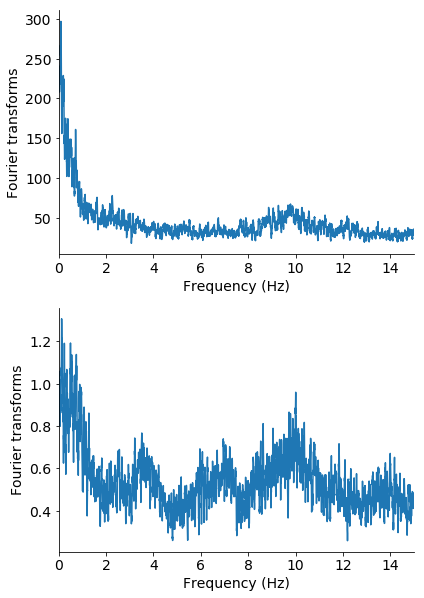

In [19]:
## residual fft

import numpy.fft as fft

fig = plt.figure(figsize=(6,12))
ax1 = plt.subplot(3,1,1);
fsz = 14;
ll = 600
spectrum = fft.fft(res[:,0])
freq = fft.fftfreq(len(spectrum), 0.025)
select = (freq>0)*(freq<15);
plt.plot(rolling_mean(freq[select]), rolling_mean((abs(spectrum)[select])))
plt.xlim([0,15]);
ax1.set_xlabel('Frequency (Hz)',fontsize=fsz,fontweight='normal');
ax1.set_ylabel('Fourier transforms',fontsize=fsz,fontweight='normal');
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.setp(ax1.get_xticklabels(), fontsize=fsz);
plt.setp(ax1.get_yticklabels(), fontsize=fsz);

ax1 = plt.subplot(3,1,2);
fsz = 14;
spectrum = fft.fft(res[:,1])
freq = fft.fftfreq(len(spectrum), 0.025)
select = (freq>0)*(freq<15);
plt.plot(rolling_mean(freq[select]), rolling_mean((abs(spectrum)[select])))
plt.xlim([0,15]);
ax1.set_xlabel('Frequency (Hz)',fontsize=fsz,fontweight='normal');
ax1.set_ylabel('Fourier transforms',fontsize=fsz,fontweight='normal');
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.setp(ax1.get_xticklabels(), fontsize=fsz);
plt.setp(ax1.get_yticklabels(), fontsize=fsz);

plt.tight_layout()

## compute geometry

In [ ]:
## posterior geometry

ll = 11;
hd_bins = np.linspace(0,1.6,ll);
select = (np.concatenate(u_all)[:,1]==1);
tc1 = get_tc_rd(outputs[0][select], np.concatenate(u_all)[select,0], hd_bins);
select = (np.concatenate(u_all)[:,2]==1);
tc2 = get_tc_rd(outputs[0][select], np.concatenate(u_all)[select,0], hd_bins);

dis_mat = np.zeros((len(tc1), len(tc2)));
for jj in range(len(tc1)):
    dis_mat[jj] = np.sqrt(np.square(tc1[jj]-tc2).sum(axis=-1))
    
## posterior w/o prior geometry

ll = 11;
hd_bins = np.linspace(0,1.6,ll);
select = (np.concatenate(u_all)[:,1]==1);
tc1 = get_tc_rd(outputs[6][select], np.concatenate(u_all)[select,0], hd_bins);
select = (np.concatenate(u_all)[:,2]==1);
tc2 = get_tc_rd(outputs[6][select], np.concatenate(u_all)[select,0], hd_bins);

dis_mat_no_pri = np.zeros((len(tc1), len(tc2)));
for jj in range(len(tc1)):
    dis_mat_no_pri[jj] = np.sqrt(np.square(tc1[jj]-tc2).sum(axis=-1))
    
## load vae latent
## lat_vae = np.load("../results/lat_vae_1d_hipp_2d.npy")

ll = 11;
hd_bins = np.linspace(0,1.6,ll);
select = (np.concatenate(u_all)[:,1]==1);
tc1 = get_tc_rd(lat_vae[select], np.concatenate(u_all)[select,0], hd_bins);
select = (np.concatenate(u_all)[:,2]==1);
tc2 = get_tc_rd(lat_vae[select], np.concatenate(u_all)[select,0], hd_bins);

dis_mat_vae = np.zeros((len(tc1), len(tc2)));
for jj in range(len(tc1)):
    dis_mat_vae[jj] = np.sqrt(np.square(tc1[jj]-tc2).sum(axis=-1))

In [ ]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.title('iVAE')
ax = seaborn.heatmap((dis_mat)/(dis_mat.max()), vmin=0,vmax=1,xticklabels=False, yticklabels=False, square=True, cmap='Greys');
ax.invert_yaxis()
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.subplot(1,3,2)
plt.title('iVAE w/o prior')
ax = seaborn.heatmap((dis_mat_no_pri)/(dis_mat_no_pri.max()), vmin=0,vmax=1,xticklabels=False, yticklabels=False, square=True, cmap='Greys');
ax.invert_yaxis()
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.subplot(1,3,3)
plt.title('VAE')
ax = seaborn.heatmap((dis_mat_vae)/(dis_mat_vae.max()), vmin=0,vmax=1,xticklabels=False, yticklabels=False, square=True, cmap='Greys');
ax.invert_yaxis()
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.tight_layout()